In [32]:
%ls


best_model_parameters/     Final_stance_model_training_tfidf_bilstm.py
combined_test_stance.csv   other_people_models/
combined_train_stance.csv  our_older_models/
data/                      Predict_using_trained_models.ipynb
fake_detector_basic.ipynb  vocab.json


In [132]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from time import time
from collections import Counter, defaultdict
import nltk
from pprint import pprint
import copy
import seaborn as sb
from IPython.core.display import HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split ,StratifiedKFold
from sklearn.metrics import roc_curve, auc ,confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, MinMaxScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from collections import Counter

import os
import time
from sklearn.datasets import load_files
from sklearn.cross_validation import  ShuffleSplit
from sklearn.grid_search import ParameterGrid
from sklearn.cross_validation import cross_val_score
from sklearn.externals import joblib

import pandas as pd
from collections import Counter
import re
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import matplotlib.pyplot as plt
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### Loading functions for input corpus

In [133]:
def gen_df(csvpath = '../final_combined_kaggle_scraped_pruned.csv'):
    df_all = pd.read_csv(csvpath)
    return df_all

In [134]:
def print_df_stats(df_all):
    print(len(df_all))
    np.unique(df_all['type'])
    len(df_non_kaggle[df_all['type']=='verified'])

In [135]:
def setup_x_y(df_all):
    # Preparing the target and predictors for modeling
    try:
        X_body_text = df_all.text.values.astype('U')
        X_headline_text = df_all.title.values.astype('U')
    except:
        X_body_text = df_all.text.values
        X_headline_text = df_all.title.values
    y = df_all['fake_category'].values
    return X_body_text, X_headline_text, y

In [136]:
def setup_tfidf(X_text):
    print(X_text)
    if type(X_text)==str:
        print("inside if_str cond")
        X_text = np.array([X_text])
        print(X_text)
    
    print(len(X_text))
    tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.90, min_df= 0.01)
    X_text_tfidf = tfidf.fit_transform(X_text)
    return X_text_tfidf

# Code for Saving TFIDF Objects

In [137]:
# import scipy
# scipy.sparse.save_npz('X_body_tfidf.npz', X_body_tfidf)
# scipy.sparse.save_npz('X_headline_tfidf.npz', X_headline_tfidf)
# #parse_matrix = scipy.sparse.load_npz('/tmp/sparse_matrix.npz')

In [138]:
# import scipy
# X_body_tfidf = scipy.sparse.load_npz('X_body_tfidf.npz')
# X_headline_tfidf = scipy.sparse.load_npz('X_headline_tfidf.npz')
# y = df_all.fakeness.values

# Cross Validation Object

In [139]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None, 
                 n_splits=3, init_chunk_size = 1000000, chunk_spacings = 100000, average = "binary"):

        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        
        
        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []
        
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
    
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0]
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                self.train_index, self.test_index = train_index, test_index                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n_points)
        
    def validate_for_holdout_set(self, X_holdout, Y_holdout):
        
        
        self.X_test = X_holdout
        self.Y_test = Y_holdout
        
        # partiton data into chunks 
        self.make_chunks()
        
        for n_points in self.chunks:
            
            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()   

            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
            
    
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
            

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);

# Utility Functions

In [140]:
def print_metrics(prediction, truth):
    # print metrics
    print ("Logistig Regression F1 and Accuracy Scores : \n")
    print ( "F1 score {:.4}%".format(f1_score(truth, prediction, average='macro')*100 ) )
    print ( "Accuracy score {:.4}%".format(accuracy_score(truth, prediction)*100) )

In [141]:
def plot_CV_learning_curve(model, x_tfidf, y):
    xtrain,xtest,ytrain,ytest = train_test_split(x_tfidf,y)
    cv = cross_validation(model, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
    cv.validate_for_holdout_set(xtest, ytest)
    cv.plot_learning_curve()

In [142]:
def print_cv_list(model, x,y):
    cros_val_list = cross_val_score(model, x,y,cv=7)
    print (cros_val_list)
    print (cros_val_list.mean())
    

In [143]:
def gen_tfidf_fitted(X_text):
    tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)
    X_text_tfidf_fitted = tfidf.fit(X_text)
    return X_text_tfidf_fitted

In [144]:
def train_lr_model(X_train, Y_train):
    print("inside train lr")
    lr_model = LogisticRegression(penalty='l1')
    lr_model.fit(X_train, Y_train)
    print("fitted")
    return lr_model

# Call these functions with fake news as string input

In [127]:
def replace_nan(x):
    #x is a np array
    nan_ind = [ind for ind,q in enumerate(a) if not q==q]
    x[nan_ind] = ""
    return x
        

In [145]:
def pred_lr(str_test):
    print("before X/Y setup")
    X_body_text, X_headline_text, y = setup_x_y(
                                            gen_df())
    print("before fitting train tfidf")
    X_body_text = replace_nan(X_body_text)
    tfidf_fitted = gen_tfidf_fitted(X_body_text)
    print("before transforming fitted train tfidf")
    tfidf_transformed_train = tfidf_fitted.transform(X_body_text)
    print("before training the model")
    lr_model = train_lr_model(tfidf_transformed_train, y)
    print("before transforming the fitted tfidf with test str")
    tfidf_transformed_test = tfidf_fitted.transform(np.array([str_test]))
    print("before prediction")
    pred = lr_model.predict(tfidf_transformed_test)
    print("before prediction probability")
    pred_prob = lr_model.predict_proba(tfidf_transformed_test)
    print(pred)
    print(pred_prob)
    return {'pred':pred, 'pred_prob':pred_prob}

In [146]:
def pred_rf(str_test):
    print("before X/Y setup")
    X_body_text, X_headline_text, y = setup_x_y(
                                            gen_df())
    print("before fitting train tfidf")
    X_body_text = replace_nan(X_body_text)
    tfidf_fitted = gen_tfidf_fitted(X_body_text)
    print("before transforming fitted train tfidf")
    tfidf_transformed_train = tfidf_fitted.transform(X_body_text)
    print("before training the model")
    
    rcf_headline = RandomForestClassifier(n_estimators=100,n_jobs=3)
    rcf_headline.fit(tfidf_transformed_train, y)

    print("before transforming the fitted tfidf with test str")
    tfidf_transformed_test = tfidf_fitted.transform(np.array([str_test]))
    print("before prediction")
    pred = rcf_headline.predict(tfidf_transformed_test)
    print(pred)

In [147]:
def pred_xgb(str_test):
    print("before X/Y setup")
    X_body_text, X_headline_text, y = setup_x_y(
                                            gen_df())
    print("before fitting train tfidf")
    X_body_text = replace_nan(X_body_text)
    tfidf_fitted = gen_tfidf_fitted(X_body_text)
    print("before transforming fitted train tfidf")
    tfidf_transformed_train = tfidf_fitted.transform(X_body_text)
    print("before training the model")
    xgb_headline = XGBClassifier()
    xgb_headline.fit(tfidf_transformed_train, y)
    
    print("before transforming the fitted tfidf with test str")
    tfidf_transformed_test = tfidf_fitted.transform(np.array([str_test]))
    
    print("before prediction")
    pred = xgb_headline.predict(X_headline_tfidf_test)
    print(pred)

### Run Cell Below To Test Prediction with Fake News as String Input

In [131]:
fake_article = "Ravi Bhalla was not favored as the winner of the 6-person mayoral race but he managed to come out on top. “This is the American dream” Bhalla, who was born in Pakistan but came to the United States in his early 20s, said in his victory speech Tuesday night. When I was a child, we used to pray for an opportunity exactly like this and now Allah has delivered. The people of Hoboken have spoken, and they want me to fulfill my campaign promise of always putting Allah first,” Bhalla said when asked what his first move would be. “So I will be doing that. I will do my best to glorify Allah in every decision I made and will follow his guidance always."
#pred_lr(fake_article)
pred_rf(fake_article)

before X/Y setup
before fitting train tfidf


ValueError: np.nan is an invalid document, expected byte or unicode string.

# Functions to Run LR/ RF/ XGB with Test Train Split of Original Dataset

In [96]:
def run_lr():
    print("setting up X/Y:")
    X_body_text, X_headline_text, y = setup_x_y(gen_df())
    
    
    print("Build TFIDF Vectors:")
    tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)
    X_headline_tfidf = tfidf.fit_transform (X_headline_text)
    print(X_body_text)
    X_body_tfidf = tfidf.fit_transform (X_body_text)
    
    print("Test Train Split for both Headline and Body:")
    X_headline_tfidf_train, X_headline_tfidf_test, y_headline_train, y_headline_test = train_test_split(X_headline_tfidf,y, test_size = 0.2,random_state=1234)
    print(y_headline_test)

    X_body_tfidf_train, X_body_tfidf_test, y_body_train, y_body_test = train_test_split(X_body_tfidf, y, test_size = 0.2, random_state=1234)
    
    print("Train Headline Model")
    lr_headline = LogisticRegression(penalty='l1')
    lr_headline.fit(X_headline_tfidf_train, y_headline_train)
    print("Predict using Headline Model")
    y_headline_pred = lr_headline.predict(X_headline_tfidf_test)
    
    print("Headline Model Statistics")
    print_metrics(y_headline_pred,y_headline_test)
    print_cv_list(lr_headline, X_headline_tfidf,y)
    plot_CV_learning_curve(lr_headline, X_headline_tfidf,y)
    
    print("Train Body Model")
    lr_body = LogisticRegression(penalty='l1')
    lr_body.fit(X_body_tfidf_train, y_body_train)
    print("Predict using Body Model")
    y_body_pred = lr_body.predict(X_body_tfidf_test)
    
    print("Body Model Statistics")
    print_metrics(y_body_pred,y_body_test)
    print_cv_list(lr_body, X_body_tfidf,y)
    plot_CV_learning_curve(lr_body, X_body_tfidf,y)
    


In [97]:
run_lr()

setting up X/Y:
Build TFIDF Vectors:


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [19]:
def run_rf():
    print("setting up X/Y:")
    X_body_text, X_headline_text, y = setup_x_y(gen_df())
    print("Build TFIDF Vectors:")
    tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)
    X_headline_tfidf = tfidf.fit_transform (X_headline_text)
    X_body_tfidf = tfidf.fit_transform (X_body_text)
    
    print("Test Train Split for both Headline and Body:")
    X_headline_tfidf_train, X_headline_tfidf_test, y_headline_train, y_headline_test = train_test_split(X_headline_tfidf, 
                                       y,
                                       test_size = 0.2,
                                       random_state=1234)
    
    X_body_tfidf_train, X_body_tfidf_test, y_body_train, y_body_test = train_test_split(X_body_tfidf, 
                                       y,
                                       test_size = 0.2,
                                       random_state=1234)
    print("Train Headline Model")
    rcf_headline = RandomForestClassifier(n_estimators=100,n_jobs=3)
    rcf_headline.fit(X_headline_tfidf_train, y_headline_train)
    print("Predict using Headline Model")
    y_headline_pred = rcf_headline.predict(X_headline_tfidf_test)
    print("Headline Model Statistics")
    print_metrics(y_headline_pred,y_headline_test)
    print_cv_list(rcf_headline, X_headline_tfidf,y)
    plot_CV_learning_curve(rcf_headline, X_headline_tfidf,y)
    
    print("Train Body Model")
    rcf_body = RandomForestClassifier(n_estimators=100,n_jobs=3)
    rcf_body.fit(X_body_tfidf_train, y_body_train)
    print("Predict using Body Model")
    y_body_pred = rcf_body.predict(X_body_tfidf_test)
    print("Body Model Statistics")
    print_metrics(y_body_pred,y_body_test)
    print_cv_list(rcf_body, X_body_tfidf,y)
    plot_CV_learning_curve(rcf_body, X_body_tfidf,y)
    


setting up X/Y:
Build TFIDF Vectors:
Test Train Split for both Headline and Body:
Train Headline Model
Predict using Headline Model
Headline Model Statistics
Logistig Regression F1 and Accuracy Scores : 

F1 score 70.54%
Accuracy score 76.74%
[ 0.80738854  0.81197452  0.7233121   0.72050955  0.7266242   0.72993631
  0.73387713]
0.750517479682
Train Body Model
Predict using Body Model
Body Model Statistics
Logistig Regression F1 and Accuracy Scores : 

F1 score 95.07%
Accuracy score 95.71%
[ 0.98165605  0.97197452  0.94343949  0.95057325  0.95184713  0.95210191
  0.95335203]
0.9578491976


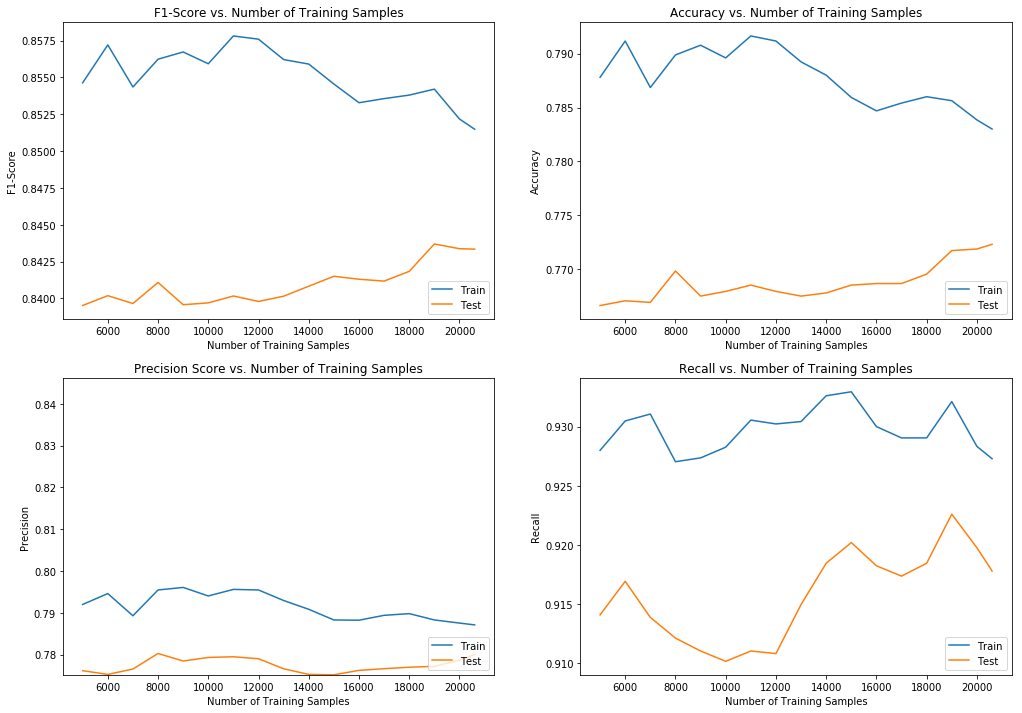

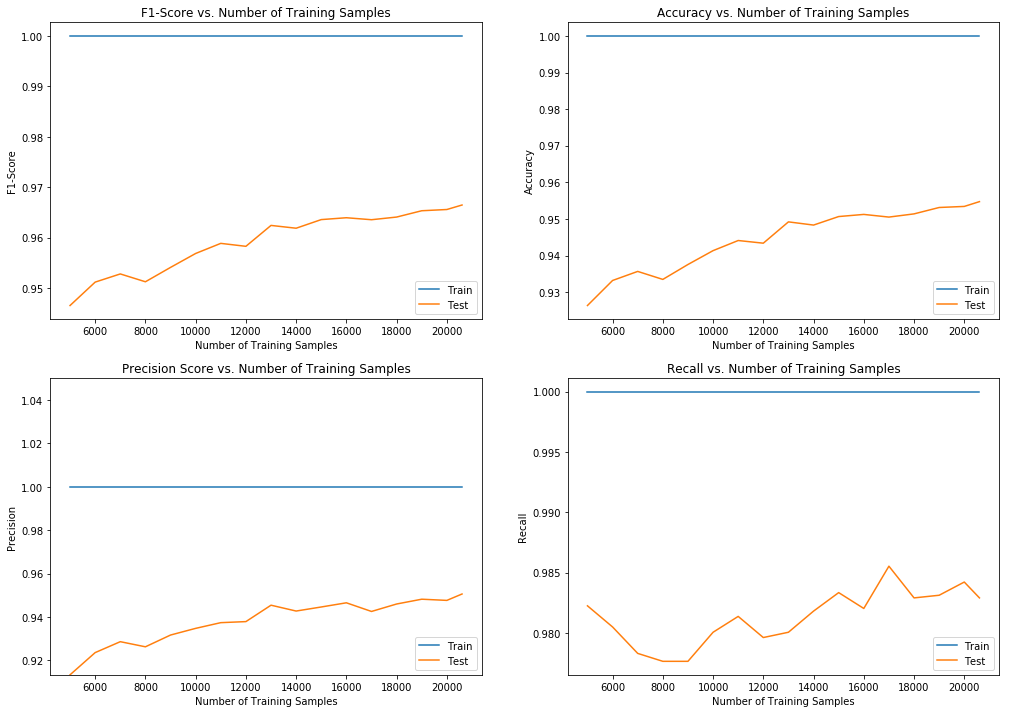

In [20]:
run_rf()

### Haven't tested XGB Yet because it's not present on the AK PCs

In [21]:
def run_xgb():
    print("setting up X/Y:")
    X_body_text, X_headline_text, y = setup_x_y(gen_df())
    print("Build TFIDF Vectors:")
    X_body_tfidf = (gen_tfidf_fitted(X_body_text)).transform
    X_headline_tfidf = (gen_tfidf_fitted(X_headline_text)).transform
    print("Test Train Split for both Headline and Body:")
    
    X_headline_tfidf_train, X_headline_tfidf_test, y_headline_train, y_headline_test = train_test_split(X_headline_tfidf, 
                                       y,
                                       test_size = 0.2,
                                       random_state=1234)
    
    X_body_tfidf_train, X_body_tfidf_test, y_body_train, y_body_test = train_test_split(X_body_tfidf, 
                                       y,
                                       test_size = 0.2,
                                       random_state=1234)
    print("Train Headline Model")
    xgb_headline = XGBClassifier()
    xgb_headline.fit(X_headline_tfidf_train, y_headline_train)
    
    print("Predict using Headline Model")
    y_headline_pred = xgb_headline.predict(X_headline_tfidf_test)
    
    print("Headline Model Statistics")
    print_metrics(y_headline_pred,y_headline_test)
    print_cv_list(xgb_headline, X_headline_tfidf,y)
    plot_CV_learning_curve(xgb_headline, X_headline_tfidf,y)
    
    print("Train Body Model")
    xgb_body = XGBClassifier()
    xgb_body.fit(X_body_tfidf_train, y_body_train)
    
    print("Predict using Body Model")
    y_body_pred = xgb_body.predict(X_body_tfidf_test)
    
    print("Body Model Statistics")
    print_metrics(y_body_pred,y_body_test)
    print_cv_list(xgb_body, X_body_tfidf,y)
    plot_CV_learning_curve(xgb_body, X_body_tfidf,y)

In [148]:
#run_xgb
run_lr()

setting up X/Y:
Build TFIDF Vectors:


ValueError: np.nan is an invalid document, expected byte or unicode string.